## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn import Parameter
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

## Parameters

In [2]:
BATCH_SIZE = 64
NUM_CLASSES = 3
INPUT_DIM = 28 * 6  # Flattened dimension (T*F)
OUTPUT_DIM = NUM_CLASSES
KL_WEIGHT = 1e-6
LR = 1e-3
EPOCHS = 15

PRIORS = {
    'prior_mu': 0.0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0.0, 0.1),
    'posterior_rho_initial': (-3.0, 0.1)
}

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Loading Files

In [3]:
X = np.load('/kaggle/input/data-usa/Site_A/x-2019.npy')
y = np.load('/kaggle/input/data-usa/Site_A/y-2019.npy')

print(X.shape, y.shape)

(2235904, 28, 6) (2235904,)


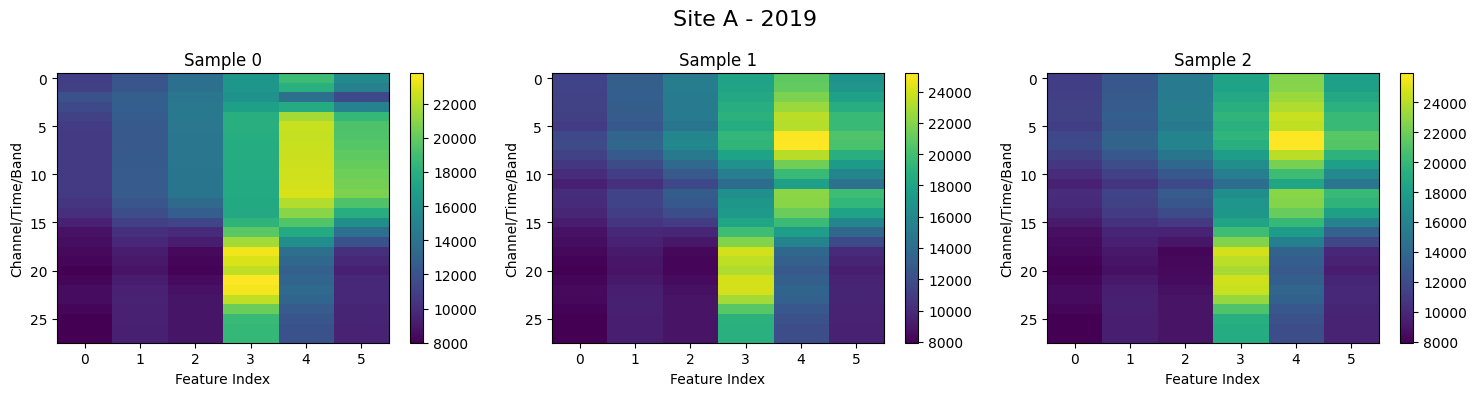

In [4]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site A - 2019", fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
print(f'\n\n======= For Site A - 2019 =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site A - 2019 =======
Feature 0: Mean = 9125.7839, Std = 954.7112
Feature 1: Mean = 10072.9565, Std = 1117.6790
Feature 2: Mean = 10259.7823, Std = 1830.2272
Feature 3: Mean = 18465.9805, Std = 4748.0298
Feature 4: Mean = 16455.6007, Std = 3182.5979
Feature 5: Mean = 13576.9940, Std = 3438.3280

Global Mean: 12992.8496
Global Std Dev: 4532.1424


## Preprocessing the Input

In [6]:
# Standardizing the input features across all timesteps and samples using Z-scores
# Compute per-feature mean and std across all samples and timesteps
feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
feature_stds = X.std(axis=(0, 1))    # Shape: (6,)

# Reshape for broadcasting
feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)

# Standardize
X_std = ((X - feature_means) / feature_stds).astype(np.float32)

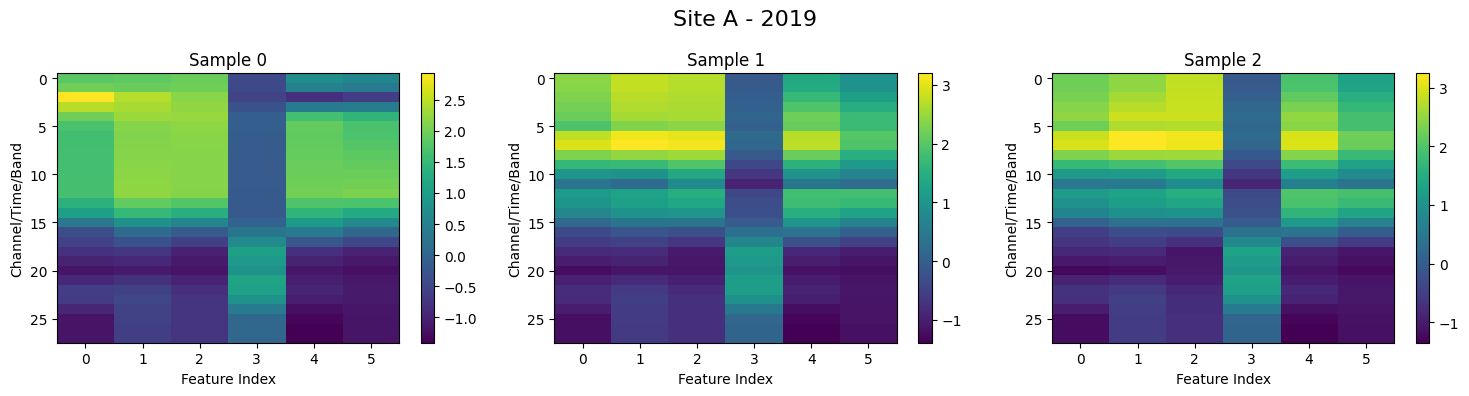

In [7]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X_std[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site A - 2019", fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
print(f'\n\n======= For Site A - 2019 =======')
feature_means = X_std.mean(axis=(0, 1))  # average over samples and features
feature_stds = X_std.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X_std.mean()
std = X_std.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site A - 2019 =======
Feature 0: Mean = 0.0000, Std = 0.8771
Feature 1: Mean = -0.0000, Std = 0.8871
Feature 2: Mean = -0.0000, Std = 0.8704
Feature 3: Mean = -0.0000, Std = 0.8796
Feature 4: Mean = 0.0000, Std = 0.8811
Feature 5: Mean = 0.0000, Std = 0.8545

Global Mean: -0.0000
Global Std Dev: 1.0000


-> So the values are now standardized across features for each timestep for each pixel.

<hr>

## Taking Subset of the data

In [9]:
# Taking only 25% percent of the data
X_subset, _, y_subset, _ = train_test_split(X_std, y, test_size=0.75, stratify=y, random_state=42)
print(X_subset.shape, y_subset.shape)

(558976, 28, 6) (558976,)


In [10]:
# Checking label distribution of the whole data
print('====== Label Distribution - Whole data ======')
unique_labels, counts = np.unique(y, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")
    
print(f"\nTotal samples: {total}")

# Checking label distribution of the subset data
print('\n\n====== Label Distribution - Subset data ======')
unique_labels, counts = np.unique(y_subset, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

====== Label Distribution - Whole data ======
Label     Count     Percentage
------------------------------
0         391359    17.50%
1         1218750   54.51%
2         625795    27.99%

Total samples: 2235904


====== Label Distribution - Subset data ======
Label     Count     Percentage
------------------------------
0         97840     17.50%
1         304687    54.51%
2         156449    27.99%

Total samples: 558976


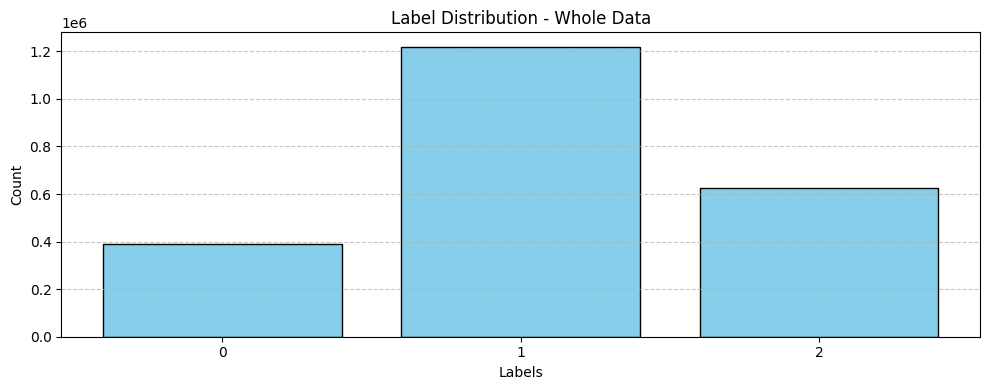

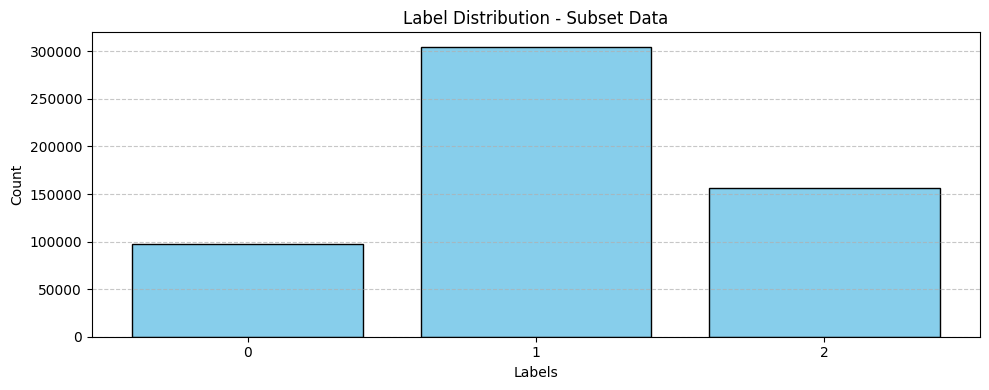

In [11]:
# Plot histogram for whole data
unique_labels, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution - Whole Data")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot histogram for subset data
unique_labels, counts = np.unique(y_subset, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution - Subset Data")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<hr>

## Train/Val Split

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(447180, 28, 6) (447180,)
(111796, 28, 6) (111796,)


In [13]:
# Checking if the training data is normalized correctly
print(f'\n\n======= Training data =======')
feature_means = X_train.mean(axis=(0, 1))  # average over samples and features
feature_stds = X_train.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X_train.mean()
std = X_train.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= Training data =======
Feature 0: Mean = 0.0003, Std = 0.9894
Feature 1: Mean = 0.0003, Std = 0.9884
Feature 2: Mean = 0.0003, Std = 0.9875
Feature 3: Mean = -0.0003, Std = 0.9919
Feature 4: Mean = 0.0003, Std = 0.9903
Feature 5: Mean = 0.0005, Std = 0.9924

Global Mean: 0.0002
Global Std Dev: 1.0000




====== Label Distribution - Training data ======
Label     Count     Percentage
------------------------------
0         78272     17.50%
1         243749    54.51%
2         125159    27.99%

Total samples: 447180


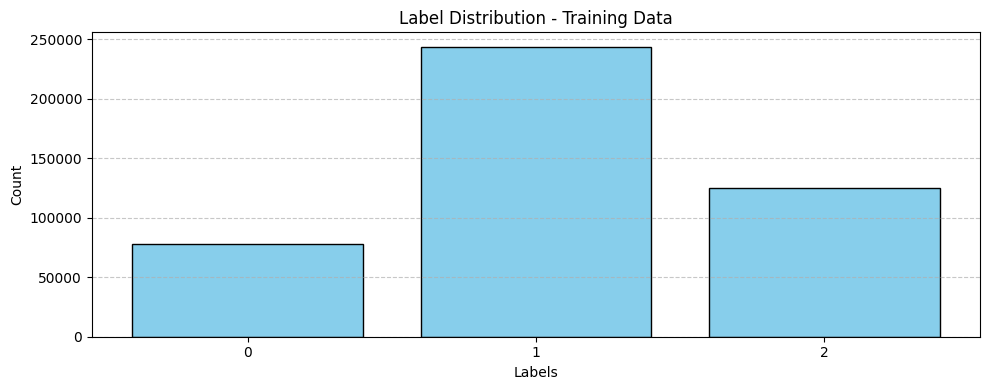

In [14]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution - Training data ======')
unique_labels, counts = np.unique(y_train, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution - Training Data")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<hr>

## Dataset and DataLoader

In [15]:
class FlattenedDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X: torch.Tensor of shape (N, T, F)
            y: torch.Tensor of shape (N,)
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        # Flatten the (T, F) into (T*F)
        x_flat = self.X[idx].reshape(-1)
        return x_flat, self.y[idx]

In [16]:
train_dataset = FlattenedDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = FlattenedDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

<hr>

## Model

In [17]:
class ModuleWrapper(nn.Module):
    """Wrapper for nn.Module with support for arbitrary flags and a universal forward pass"""

    def __init__(self):
        super(ModuleWrapper, self).__init__()

    def set_flag(self, flag_name, value):
        setattr(self, flag_name, value)
        for m in self.children():
            if hasattr(m, 'set_flag'):
                m.set_flag(flag_name, value)

    def forward(self, x, sample=True):
        num_layers = sum(1 for _ in self.children())
        for i, module in enumerate(self.children()):
            if 'BBB' in module._get_name() and i < num_layers - 1:
                x = module(x, sample=sample)
            elif 'BBB' in module._get_name():
                x = module(x, sample=sample)
            else:
                x = module(x)

        kl = 0.0
        for module in self.modules():
            if hasattr(module, 'kl_loss'):
                kl = kl + module.kl_loss()

        return x, kl

In [18]:
class BBBLinear(ModuleWrapper):
    def __init__(self, in_features, out_features, bias=True, priors=None, device=DEVICE):
        super(BBBLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = bias
        self.device = device

        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        self.W_mu = Parameter(torch.empty((out_features, in_features), device=self.device))
        self.W_rho = Parameter(torch.empty((out_features, in_features), device=self.device))

        if self.use_bias:
            self.bias_mu = Parameter(torch.empty((out_features), device=self.device))
            self.bias_rho = Parameter(torch.empty((out_features), device=self.device))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)

        if self.use_bias:
            self.bias_mu.data.normal_(*self.posterior_mu_initial)
            self.bias_rho.data.normal_(*self.posterior_rho_initial)

    def forward(self, input, sample=True):
        if sample:
            W_eps = torch.empty(self.W_mu.size()).normal_(0, 1).to(self.device)
            self.W_sigma = torch.log1p(torch.exp(self.W_rho))
            weight = self.W_mu + W_eps * self.W_sigma

            if self.use_bias:
                bias_eps = torch.empty(self.bias_mu.size()).normal_(0, 1).to(self.device)
                self.bias_sigma = torch.log1p(torch.exp(self.bias_rho))
                bias = self.bias_mu + bias_eps * self.bias_sigma
            else:
                bias = None
            return F.linear(input, weight, bias)
        else:
            weight = self.W_mu
            self.W_sigma = torch.log1p(torch.exp(self.W_rho))
            self.bias_sigma = torch.log1p(torch.exp(self.bias_rho))
            bias = self.bias_mu if self.use_bias else None
            return F.linear(input, weight, bias)

    def kl_loss(self):
        kl = KL_DIV(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            kl += KL_DIV(self.prior_mu, self.prior_sigma, self.bias_mu, self.bias_sigma)
        return kl


def KL_DIV(mu_q, sig_q, mu_p, sig_p):
    kl = 0.5 * (2 * torch.log(sig_p / sig_q) - 1 + (sig_q / sig_p).pow(2) + ((mu_p - mu_q) / sig_p).pow(2)).sum()
    return kl

In [19]:
class BBBMLP(ModuleWrapper):
    '''The architecture of LeNet with Bayesian Layers'''

    def __init__(self, inputs, outputs, priors, device=DEVICE):
        super(BBBMLP, self).__init__()

        self.num_classes = outputs
        self.priors = priors
        self.act = nn.ReLU

        self.fc0 = BBBLinear(inputs, 256, bias=True, priors=self.priors, device=device)
        self.act0 = self.act()

        self.fc1 = BBBLinear(256, 128, bias=True, priors=self.priors, device=device)
        self.act1 = self.act()

        self.fc2 = BBBLinear(128, 64, bias=True, priors=self.priors, device=device)
        self.act2 = self.act()

        self.fc3 = BBBLinear(64, 32, bias=True, priors=self.priors, device=device)
        self.act3 = self.act()

        self.fc4 = BBBLinear(32, outputs, bias=True, priors=self.priors, device=device)

In [20]:
model = BBBMLP(inputs=INPUT_DIM, outputs=OUTPUT_DIM, priors=PRIORS).to(DEVICE)
print(model)

BBBMLP(
  (fc0): BBBLinear()
  (act0): ReLU()
  (fc1): BBBLinear()
  (act1): ReLU()
  (fc2): BBBLinear()
  (act2): ReLU()
  (fc3): BBBLinear()
  (act3): ReLU()
  (fc4): BBBLinear()
)


<hr>

## Loss Function and Optimizer

In [21]:
# First, collect all labels from your training dataset
all_labels = []

for _, y_batch in train_dataloader:
    all_labels.append(y_batch.numpy())

# Flatten all labels into a 1D array
all_labels = np.concatenate(all_labels)

# Compute class weights
classes = np.unique(all_labels)
class_weights_np = compute_class_weight(class_weight='balanced', classes=classes, y=all_labels)

# Convert to tensor
class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(DEVICE)
print(class_weights)

tensor([1.9044, 0.6115, 1.1910], device='cuda:0')


In [22]:
ce_loss = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [23]:
def ELBO_loss(outputs, y_batch, kl, kl_weight=KL_WEIGHT):
    return ce_loss(outputs, y_batch)  + kl_weight * kl

<hr>

## Training Loop

In [24]:
def compute_accuracy(preds, labels):
    _, preds_max = torch.max(preds, dim=1)
    return (preds_max == labels).float().mean().item()

def compute_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred)

In [25]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(EPOCHS):
    # === TRAIN ===
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for x_batch, y_batch in tqdm(train_dataloader, desc='Training'):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad()

        outputs, kl = model(x_batch, sample=True)  # sample=True for MC Dropout

        # ELBO Loss
        loss = ELBO_loss(outputs, y_batch, kl, KL_WEIGHT)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_batch.size(0)
        train_acc += compute_accuracy(outputs, y_batch) * x_batch.size(0)

    train_loss /= len(train_dataset)
    train_acc /= len(train_dataset)

    # === VALIDATION ===
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for x_batch, y_batch in tqdm(val_dataloader, desc='Validation'):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            outputs, kl = model(x_batch, sample=False)  # sample=False for deterministic eval

            # ELBO Loss
            loss = ELBO_loss(outputs, y_batch, kl, KL_WEIGHT)

            val_loss += loss.item() * x_batch.size(0)
            val_acc += compute_accuracy(outputs, y_batch) * x_batch.size(0)

    val_loss /= len(val_dataset)
    val_acc /= len(val_dataset)

    # === Logging ===
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Validation: 100%|██████████| 1747/1747 [00:05<00:00, 323.13it/s]


Epoch [1/15] Train Loss: 0.2996, Train Acc: 0.9328 | Val Loss: 0.2120, Val Acc: 0.9410


Validation: 100%|██████████| 1747/1747 [00:05<00:00, 326.32it/s]


Epoch [2/15] Train Loss: 0.2092, Train Acc: 0.9406 | Val Loss: 0.1898, Val Acc: 0.9465


Validation: 100%|██████████| 1747/1747 [00:05<00:00, 325.77it/s]


Epoch [3/15] Train Loss: 0.1942, Train Acc: 0.9420 | Val Loss: 0.1756, Val Acc: 0.9454


Validation: 100%|██████████| 1747/1747 [00:05<00:00, 320.20it/s]


Epoch [4/15] Train Loss: 0.1886, Train Acc: 0.9428 | Val Loss: 0.1738, Val Acc: 0.9464


Validation: 100%|██████████| 1747/1747 [00:05<00:00, 323.20it/s]


Epoch [5/15] Train Loss: 0.1840, Train Acc: 0.9436 | Val Loss: 0.1695, Val Acc: 0.9471


Validation: 100%|██████████| 1747/1747 [00:05<00:00, 322.85it/s]


Epoch [6/15] Train Loss: 0.1808, Train Acc: 0.9435 | Val Loss: 0.1702, Val Acc: 0.9432


Validation: 100%|██████████| 1747/1747 [00:05<00:00, 327.14it/s]


Epoch [7/15] Train Loss: 0.1789, Train Acc: 0.9441 | Val Loss: 0.1655, Val Acc: 0.9470


Validation: 100%|██████████| 1747/1747 [00:05<00:00, 322.15it/s]


Epoch [8/15] Train Loss: 0.1772, Train Acc: 0.9444 | Val Loss: 0.1668, Val Acc: 0.9456


Validation: 100%|██████████| 1747/1747 [00:05<00:00, 326.61it/s]


Epoch [9/15] Train Loss: 0.1763, Train Acc: 0.9449 | Val Loss: 0.1654, Val Acc: 0.9484


Validation: 100%|██████████| 1747/1747 [00:05<00:00, 321.58it/s]


Epoch [10/15] Train Loss: 0.1754, Train Acc: 0.9448 | Val Loss: 0.1639, Val Acc: 0.9463


Validation: 100%|██████████| 1747/1747 [00:05<00:00, 329.30it/s]


Epoch [11/15] Train Loss: 0.1749, Train Acc: 0.9447 | Val Loss: 0.1670, Val Acc: 0.9442


Validation: 100%|██████████| 1747/1747 [00:05<00:00, 316.72it/s]


Epoch [12/15] Train Loss: 0.1736, Train Acc: 0.9448 | Val Loss: 0.1614, Val Acc: 0.9496


Validation: 100%|██████████| 1747/1747 [00:05<00:00, 326.14it/s]


Epoch [13/15] Train Loss: 0.1733, Train Acc: 0.9453 | Val Loss: 0.1615, Val Acc: 0.9484


Validation: 100%|██████████| 1747/1747 [00:05<00:00, 323.35it/s]


Epoch [14/15] Train Loss: 0.1727, Train Acc: 0.9455 | Val Loss: 0.1623, Val Acc: 0.9463


Validation: 100%|██████████| 1747/1747 [00:05<00:00, 326.50it/s]

Epoch [15/15] Train Loss: 0.1727, Train Acc: 0.9454 | Val Loss: 0.1608, Val Acc: 0.9470


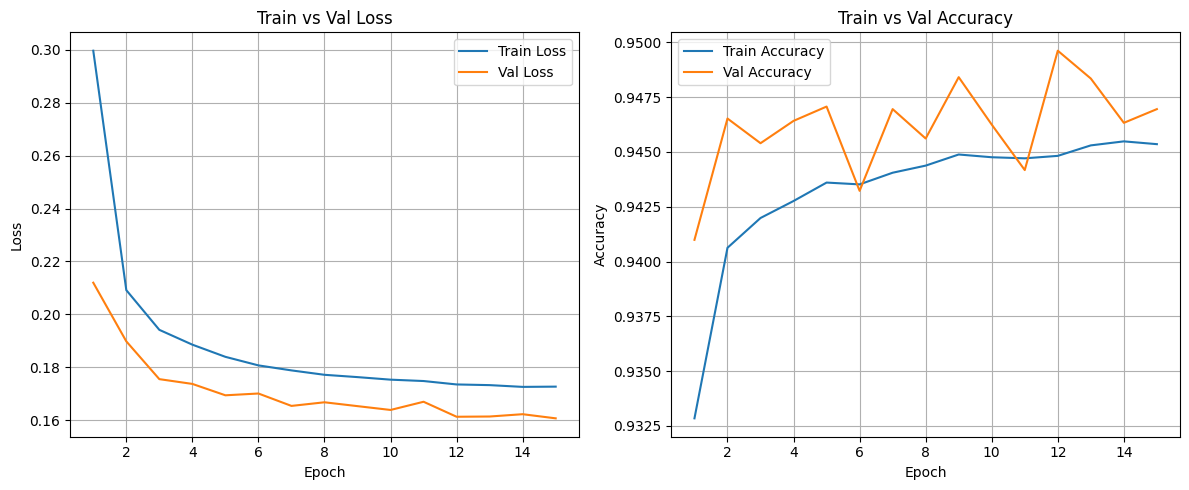

In [26]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Val Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<hr>

## Evaluation Metrics

In [27]:
# Confusion Matrix
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(val_dataloader, desc="Collecting for Confusion Matrix"):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        outputs, _ = model(x_batch, sample=False)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(y_batch.cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Calculating Kappa
kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())
print(f"Cohen's Kappa: {kappa:.4f}")


# Compute per-class F1
per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)
print('Per Class F1:',per_class_f1)

Cohen's Kappa: 0.9122
Per Class F1: [0.89052804 0.96530659 0.95064952]


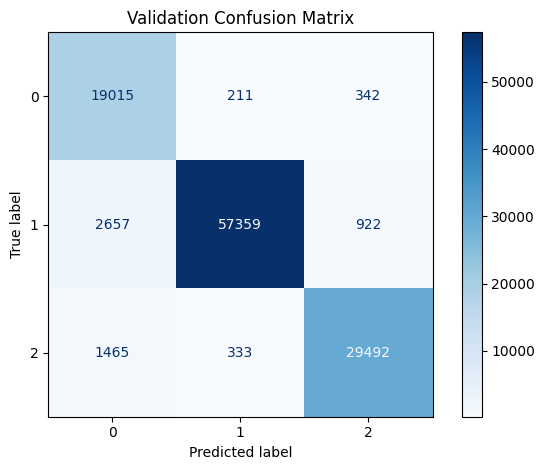

In [28]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.tight_layout()
plt.show()

<hr>